In [2]:
!pip install pmdarima
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#df1 = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
#df2 = pd.read_csv("Sheriff_and_Police_Stations.csv")
df1 = pd.read_csv('/content/drive/MyDrive/Crime_Data_from_2020_to_Present.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Sheriff_and_Police_Stations.csv')

In [ ]:
df1['DATE OCC'] = pd.to_datetime(df1['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

df1['YearMonth'] = df1['DATE OCC'].dt.to_period('M').astype(str)
df1 = df1.sort_values(by='DATE OCC')
# Crear el gráfico de dispersión con un control deslizante para cambiar las fechas
fig = px.scatter_mapbox(df1, lat="LAT", lon="LON", color="Crm Cd Desc", hover_name="Crm Cd Desc",
                        hover_data=["DATE OCC", "AREA NAME", "Vict Sex", "Vict Age"],
                        animation_frame="YearMonth", zoom=10, height=600)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":0,"l":0,"b":0},
    clickmode='event+select'
)

police_stations = go.Scattermapbox(
    lat=df2['latitude'],
    lon=df2['longitude'],
    text=df2['name'],
    hoverinfo='text',
    mode='markers',
    marker=dict(size=10, color='blue', opacity=0.8),
    name='Estaciones de Policía'
)

# Añadir el scattermapbox de las estaciones de policía a cada frame
for frame in fig.frames:
    frame.data += (go.Scattermapbox(
        lat=df2['latitude'],
        lon=df2['longitude'],
        text=df2['name'],
        hoverinfo='text',
        mode='markers',
        marker=dict(size=10, color='blue', opacity=0.8),
        name='Estaciones de Policía'
    ),)

# Añadir el scattermapbox de las estaciones de policía a la figura principal
fig.add_trace(police_stations)

# Forzar la actualización de los frames para asegurar que contengan las estaciones de policía
fig.update(frames=fig.frames)

fig.show()

In [ ]:
df1['DATE OCC'] = pd.to_datetime(df1['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df1['YearMonth'] = df1['DATE OCC'].dt.to_period('M').astype(str)
crimes_per_zone_time = df1.groupby(['AREA NAME', 'YearMonth']).size().reset_index(name='CrimeCount')
fig = px.bar(crimes_per_zone_time,
             x='AREA NAME',
             y='CrimeCount',
             color='AREA NAME',
             animation_frame='YearMonth',
             animation_group='AREA NAME',
             range_y=[0, crimes_per_zone_time['CrimeCount'].max()],
             title='Crímenes por Zona a lo largo del tiempo')
fig.show()

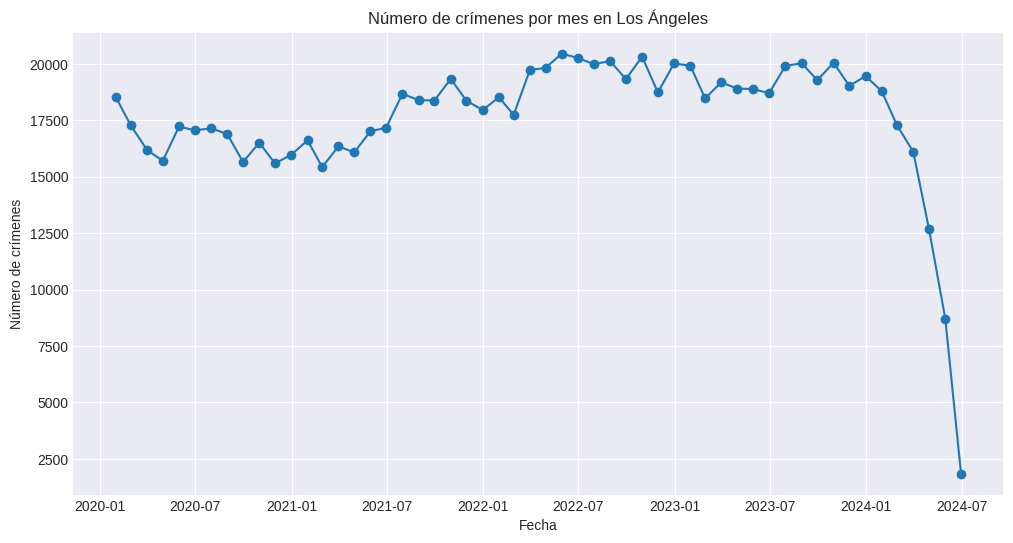

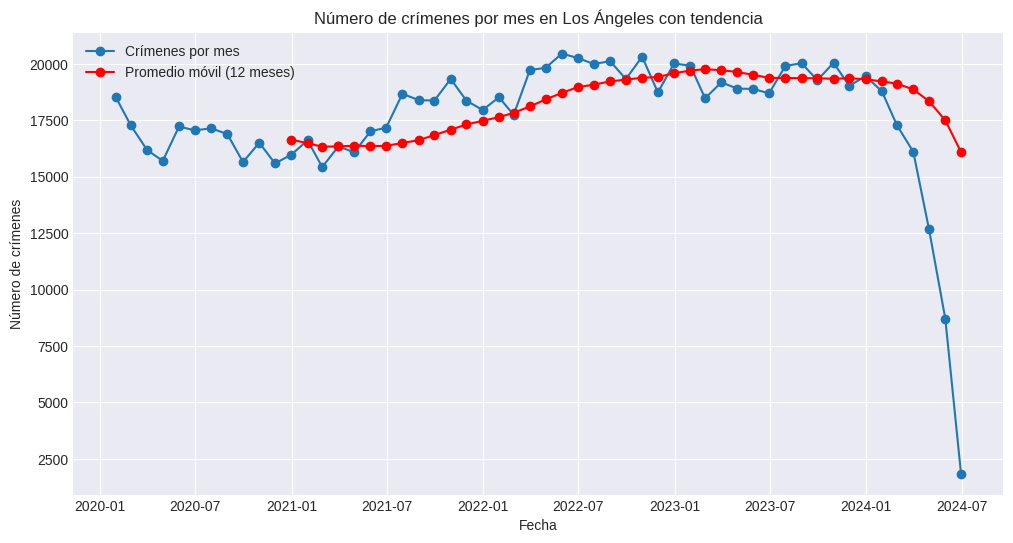

In [7]:
# Convertir la columna 'DATE OCC' a tipo datetime
df1['DATE OCC'] = pd.to_datetime(df1['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# Establecer 'DATE OCC' como índice
df1.set_index('DATE OCC', inplace=True)

# Resamplear los datos por mes y contar el número de crímenes en cada mes
crimes_per_month = df1.resample('M').size()

# Crear el gráfico de la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(crimes_per_month, marker='o', linestyle='-')
plt.title('Número de crímenes por mes en Los Ángeles')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.grid(True)
plt.show()

# Mostrar patrones y tendencias utilizando un promedio móvil
crimes_per_month_rolling = crimes_per_month.rolling(window=12).mean()

# Crear el gráfico de la serie de tiempo con la tendencia
plt.figure(figsize=(12, 6))
plt.plot(crimes_per_month, marker='o', linestyle='-', label='Crímenes por mes')
plt.plot(crimes_per_month_rolling, marker='o', linestyle='-', color='red', label='Promedio móvil (12 meses)')
plt.title('Número de crímenes por mes en Los Ángeles con tendencia')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.legend()
plt.grid(True)
plt.show()

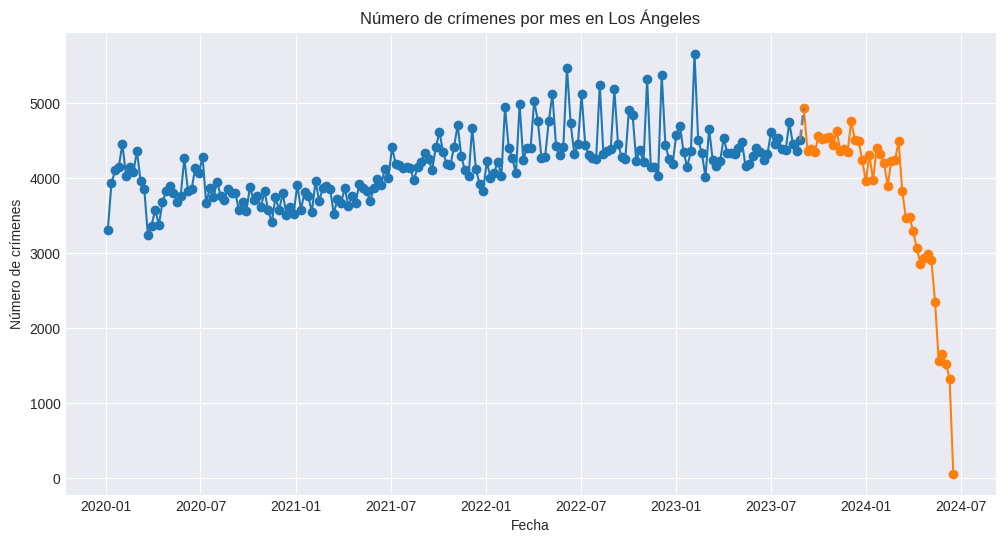

In [40]:
df1 = df1.sort_values(by='DATE OCC')
train_size = int(len(df1) * 0.8)

#train = df1[:train_size]
#test = df1[train_size:]
#crimes_per_day_train = train.resample('W').size()
#crimes_per_day_test = test.resample('W').size()

original_date = df1.iloc[train_size,1]
original_date = pd.to_datetime(original_date)
new_date = original_date - pd.offsets.Week(weekday=6)
mes_siguiente = new_date + pd.offsets.Week(weekday=0)

# Divide los datos en conjuntos de entrenamiento y prueba
train_graph = df1[:new_date]
test_graph  = df1[mes_siguiente:]

crimes_train = train_graph.resample('W').size()
crimes_test = test_graph.resample('W').size()

# Crear el gráfico de la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(crimes_train, marker='o', linestyle='-')
plt.plot(crimes_test, marker='o', linestyle='-')
plt.plot([crimes_train.index[-1], crimes_test.index[0]],
         [crimes_train.iloc[-1], crimes_test.iloc[0]],
         color='gray', linestyle='--', linewidth=2)
plt.title('Número de crímenes por mes en Los Ángeles')
plt.xlabel('Fecha')
plt.ylabel('Número de crímenes')
plt.grid(True)
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -1.2452453904414111, p-value: 0.6538359465860242
KPSS Statistic: 1.6813123409184858, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -5.4292571228109034, p-value: 2.939477964026401e-06
KPSS Statistic: 0.08051984162635789, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -6.066101031129339, p-value: 1.180797127932735e-07
KPSS Statistic: 0.0488832769005981, p-value: 0.1

Test estacionariedad para serie diferenciada (order=3)
--------------------------------------------------
ADF Statistic: -9.800582996289236, p-value: 6.010156524910277e-17
KPSS Statistic: 0.05126150637507863, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 3'}, xlabel='DATE OCC'>

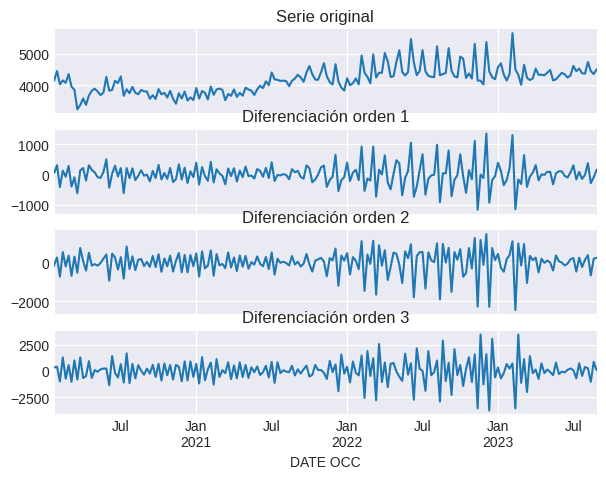

In [43]:
warnings.filterwarnings("ignore")
diff_1 = crimes_train.diff().dropna()
diff_2 = diff_1.diff().dropna()
diff_3 = diff_2.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(crimes_train)
kpss_result = kpss(crimes_train)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(diff_1)
kpss_result = kpss(diff_1.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(diff_2)
kpss_result = kpss(diff_2.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=3)')
print('--------------------------------------------------')
adfuller_result = adfuller(diff_3)
kpss_result = kpss(diff_3.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")


fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 5), sharex=True)
crimes_train.plot(ax=axs[0], title='Serie original')
diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
diff_2.plot(ax=axs[2], title='Diferenciación orden 2')
diff_3.plot(ax=axs[3], title='Diferenciación orden 3')

El p-value obtenido tras la primera diferenciación es estadísticamente significativo acorde al umbral ampliamente reconocido y aceptado de 0.05. Por lo tanto, la selección más adecuada para el parámetro ARIMA 𝑑 es 3.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'PACF')

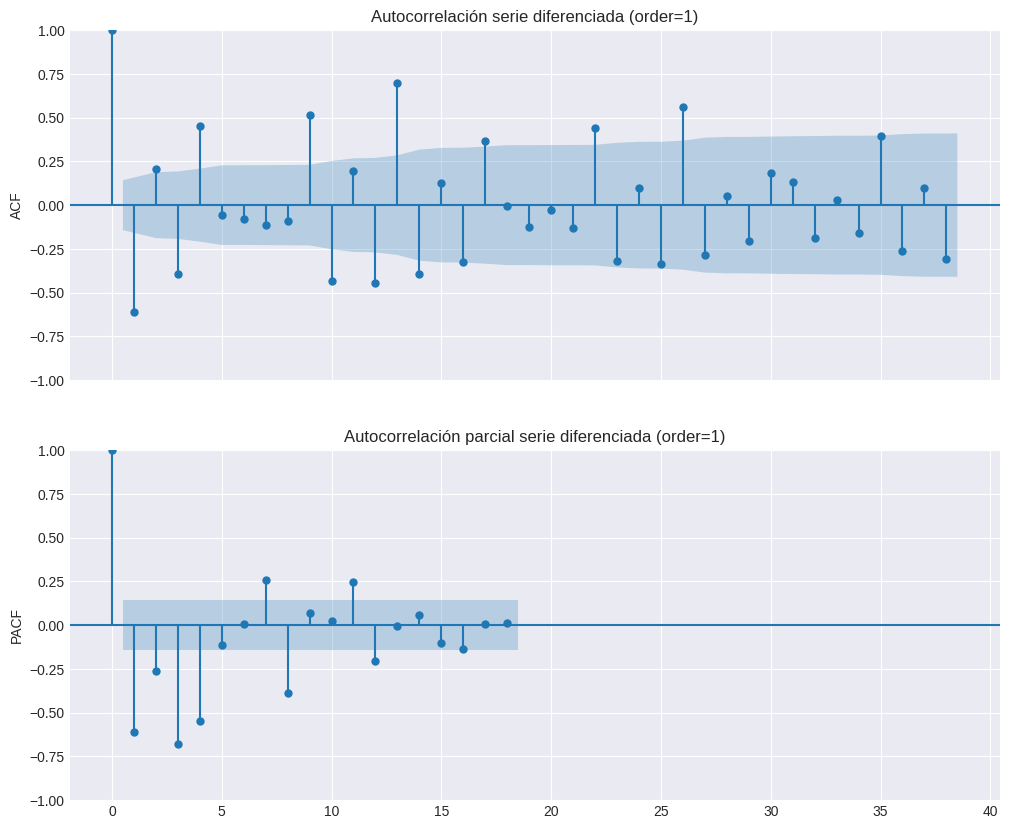

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)


plot_acf(diff_2, ax=axs[0], lags=38, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada (order=2)')
axs[0].set_ylabel('ACF')


plot_pacf(diff_2, ax=axs[1], lags=18, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada (order=2)')
axs[1].set_ylabel('PACF')

Acorde a la función de autocorrelación, el valor óptimo para el parámetro 𝑝 es 1. Sin embargo, se va a asignar un valor de 1 para proporcionar un componente autorregresivo al modelo. En cuanto al componente 𝑞 , la función de autocorrelación parcial sugiere un valor de 6.

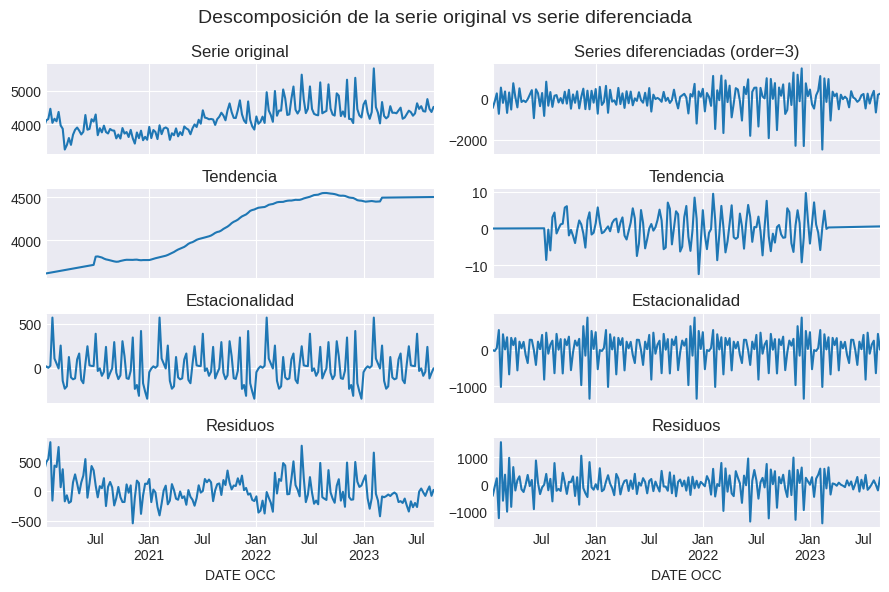

In [46]:
res_decompose = seasonal_decompose(crimes_train, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(diff_2, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=3)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()

El patrón recurrente cada 2 meses sugiere una estacionalidad anual, probablemente influenciada por factores vacacionales. El gráfico de ACF respalda aún más la presencia de esta estacionalidad, ya que se observan picos significativos en los lags correspondientes a los intervalos de 2 meses, confirmando la idea de patrones recurrentes.

In [57]:
modelo = auto_arima(
            y                 = crimes_train,
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 4, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2761.797, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2856.783, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=2720.594, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=2730.975, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3729.920, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=2776.310, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=2698.845, Time=1.10 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=2716.983, Time=0.59 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=2693.052, Time=1.40 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=2697.393, Time=0.82 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=2712.477, Time=2.54 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=2721.259, Time=0.54 sec
 ARIMA(2,0,0)(1,0,2)[4] intercept   : AIC=26

In [61]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = crimes_train, order = (1, 0, 2), seasonal_order = (0, 0, 2, 4))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
predicciones_statsmodels = modelo_res.get_forecast(steps=len(crimes_test)).predicted_mean

In [62]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order = (1, 0, 2), seasonal_order = (0, 0, 2, 4))
modelo.fit(y=crimes_train)
warnings.filterwarnings("default")
predicciones_skforecast = modelo.predict(steps=len(crimes_test))

In [63]:
modelo = ARIMA(order = (1, 0, 2), seasonal_order = (0, 0, 2, 4))
modelo.fit(y=crimes_train)
predicciones_pdmarima = modelo.predict(len(crimes_test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


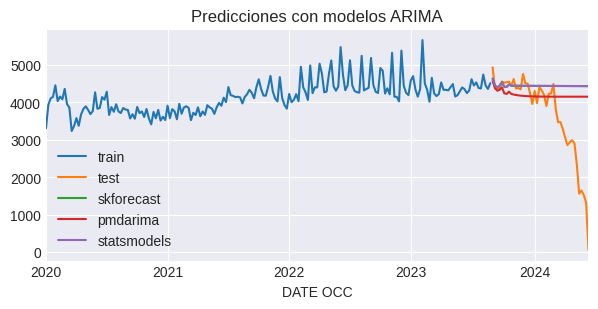

In [64]:
fig, ax = plt.subplots(figsize=(7, 3))
crimes_train.plot(ax=ax, label='train')
crimes_test.plot(ax=ax, label='test')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

Statsmodel y Skforecast son iguales

In [65]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order = (1, 0, 2), seasonal_order = (0, 0, 2, 4))
             )
forecaster.fit(y=crimes_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(crimes_test))

In [66]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order = (1, 0, 2),
                                seasonal_order = (0, 0, 2, 4),
                                maxiter=200
                            )
             )
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = pd.concat([crimes_train, crimes_test]),
                            initial_train_size    = len(crimes_train),
                            fixed_train_size      = False,
                            steps                 = 4,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 191
Number of observations used for backtesting: 42
    Number of folds: 11
    Number of steps per fold: 4
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2020-01-05 00:00:00 -- 2023-08-27 00:00:00  (n=191)
    Validation: 2023-09-03 00:00:00 -- 2023-09-24 00:00:00  (n=4)
Fold: 1
    Training:   2020-01-05 00:00:00 -- 2023-09-24 00:00:00  (n=195)
    Validation: 2023-10-01 00:00:00 -- 2023-10-22 00:00:00  (n=4)
Fold: 2
    Training:   2020-01-05 00:00:00 -- 2023-10-22 00:00:00  (n=199)
    Validation: 2023-10-29 00:00:00 -- 2023-11-19 00:00:00  (n=4)
Fold: 3
    Training:   2020-01-05 00:00:00 -- 2023-11-19 00:00:00  (n=203)
    Validation: 2023-11-26 00:00:00 -- 2023-12-17 00:00:00  (n=4)
Fold: 4
    Training:   2020-01-05 00:00:00 -- 2023-12-17 00:00:00  (n=207)


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


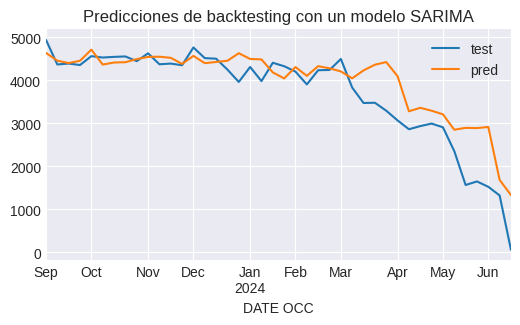

In [67]:
fig, ax = plt.subplots(figsize=(6, 3))
crimes_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend();